In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import animation
import h5py
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes',labelsize=10) 
loc = 'sector001_camera1_ccd2'
ddir = '/Users/Oliver/PhD/TASOC/TESS_data/'+loc+'.hdf5'
title = 'TESS '+loc.replace('_',' ')
title

'TESS sector001 camera1 ccd2'

## TODO:
- Find a way to exlude 'small' clusters or chose to include them entirely
- Find a way to do this consistently for all sizes
- Test on CCD4, Camera 1

In [2]:
f = h5py.File(ddir, 'r', libver='latest')

In [3]:
indices = np.array(list(f['backgrounds']))[::50]

Important note:
I am only checking the functionality as it appears in the `photometry` `backgrounds.py` code, and not worrying about smoothing in time.

## Using the TASOC data

In [4]:
globmin = np.array([np.nanmin(np.array(f['images'][idx])) for idx in indices]).min()
sumimage = np.array(f['sumimage'])
def nanmask(diffim):
    from statsmodels import robust
    return (diffim>(np.median(diffim)+np.std(diffim)*0.5))

In [5]:
def get_bkg(idx):
    return np.log10(np.array(f['backgrounds'][idx]))
def get_image(idx):
    return np.log10(np.array(f['images'][idx]+np.array(f['backgrounds'][idx])))
def get_corr(idx):
    im = np.array(f['images'][idx])
    diffim = np.abs(im - sumimage)
#     im[nanmask(diffim)] = np.nan
    immin = np.nanmin(im)
    if immin <= 0:
        return np.log10(im + np.abs(globmin))
    else:
        return np.log10(im)

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
fig.suptitle(title,fontsize=20)

gs = gridspec.GridSpec(1, 3, figure=fig,wspace=0, hspace=0)
ax1 = plt.subplot(gs[:, :1])
ax2 = plt.subplot(gs[:, 1:2])
ax0 = plt.subplot(gs[:, 2:])


im0 = ax0.imshow(get_corr('0000'), animated=True, origin='lower',
                 vmin = np.nanmin(get_bkg('0000')), vmax = np.nanmax(get_bkg('0000'))*2)
im = ax1.imshow(get_image('0000'), animated=True, origin='lower',
                vmin=np.nanmin(get_bkg('0000')), vmax=np.nanmax(get_bkg('0000')))
im2 = ax2.imshow(get_bkg('0000'), animated=True, origin='lower', 
                 vmin=np.nanmin(get_bkg('0000')), vmax=np.nanmax(get_bkg('0000')))

divider = make_axes_locatable(ax0)
cax2 = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im0, cax=cax2,label=r'$\log_{10}(Flux)$')
                                   
ax0.set_title('Background removed',fontsize=15)    
ax1.set_title('Raw image',fontsize=15)
ax2.set_title('Background estimate',fontsize=15)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

def updatefig(idx):
    im0.set_array(get_corr(idx))
    im.set_array(get_image(idx))
    im2.set_array(get_bkg(idx))
    return im, im2,             
    
ani = animation.FuncAnimation(fig, updatefig, frames=indices,
                             blit=True, repeat=True, interval = 400)
plt.close(fig)
HTML(ani.to_html5_video())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


In [7]:
ani.save(loc+'.gif', dpi=1080, writer='pillow')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


TODO: Try with dbscan

## Flagging with Percentile / Mode+Mad

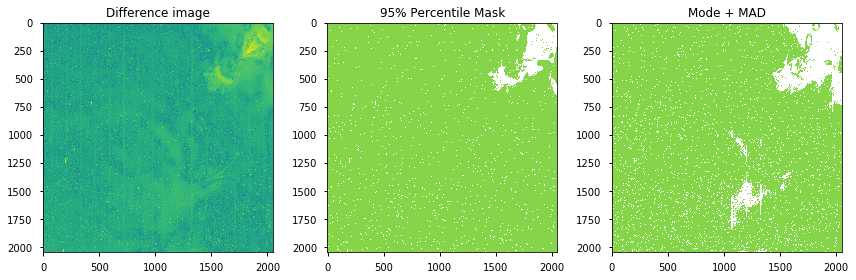

In [8]:
from scipy import stats
from statsmodels import robust

def nanmask(diffim):
    per = diffim < np.nanpercentile(diffim, [90])
    nan = np.isfinite(diffim[per])

    kde = stats.gaussian_kde(diffim[per][nan], bw_method='scott')
    alpha = np.linspace(np.nanmin(diffim[per]), np.nanmax(diffim[per]), 100)
    mode = alpha[np.argmax(kde(alpha))]
    mad = robust.scale.mad(diffim[per][nan].flatten())
    return (diffim>(mode+5*mad))

def nanmaskperc(diffim):
    return (diffim > np.nanpercentile(diffim,[95]))

sumimage = np.array(f['sumimage']+np.abs(globmin))
diffim = np.abs(10**get_corr('0000') - sumimage)

fig, ax = plt.subplots(1,3,figsize=(12,6))
im = ax[0].imshow(np.log10(diffim))
ax[0].set_title('Difference image')
# fig.colorbar(im, ax=ax[0])

im = get_corr('0000')
im[nanmaskperc(diffim)] = np.nan
ax[1].imshow(im, vmin=np.log10(np.nanmin(diffim)), vmax=np.log10(np.nanmax(diffim)))
ax[1].set_title('95% Percentile Mask')

im = get_corr('0000')
im[nanmask(diffim)] = np.nan
ax[2].imshow(im, vmin=np.log10(np.nanmin(diffim)), vmax=np.log10(np.nanmax(diffim)))
ax[2].set_title('Mode + MAD')
fig.tight_layout()
plt.show()

## DBSCAN method

In [27]:
from sklearn.cluster import DBSCAN
NX, NY = diffim.shape
X, Y = np.meshgrid(np.arange(NX), np.arange(NY))

#initiating the dbscan parameters
sel = nanmask(diffim)
x = np.zeros([len(diffim[sel]), 2])
x[:,0] = X[sel]
x[:,1] = Y[sel]

#Run DBSCAN
db = DBSCAN(eps = np.sqrt(2), min_samples=8).fit(x)
labels = db.labels_
unique_labels = set(labels)

#Output the cluster information
info = np.ones([len(unique_labels),2])
veil = np.zeros(X.shape)
veil -= 1
veil[veil==-1] = np.nan

for k in unique_labels:
    class_member_mask = (labels == k)
    xy = x[class_member_mask]

    if k!= -1:
        info[k,0] = k
        info[k,1] = len(xy)
        
        for i, row in enumerate(xy):
            veil[int(xy[i,1]), int(xy[i,0])] = k

# cutoff = np.nanmedian(info[:,1]) + np.nanstd(info[:,1])
veil[veil==-1] = np.nan
# for i in info[info[:,1] < cutoff][:,0]:
#     veil[veil==i] = np.nan

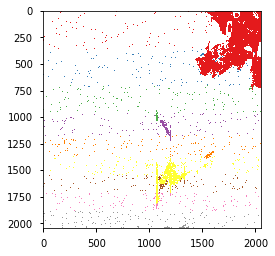

In [29]:
plt.imshow(veil,cmap='Set1')

In [11]:
sys.exit()

NameError: name 'sys' is not defined

### A fun test as an aside

In [ ]:
locs = ['sector001_camera1_ccd1', 'sector001_camera1_ccd2', 'sector001_camera3_ccd1']


In [ ]:
from tqdm import tqdm

for loc in locs:
    ddir = '/Users/Oliver/PhD/TASOC/TESS_data/'+loc+'.hdf5'
    title = 'TESS '+loc.replace('_',' ')
    f = h5py.File(ddir, 'r', libver='latest')
    
    flux = np.zeros(len(list(f['backgrounds'])))
    for idx, i in tqdm(enumerate(list(f['backgrounds']))):
        flux[idx] = np.sum(f['backgrounds'][i])
    time = np.array(f['time'])
    np.savetxt('../TESS_data/'+loc+'.txt',list(zip(time,flux)))

In [ ]:
t111, f111 = np.genfromtxt('../TESS_data/'+locs[0]+'.txt').T
t112, f112 = np.genfromtxt('../TESS_data/'+locs[1]+'.txt').T
t131, f131 = np.genfromtxt('../TESS_data/'+locs[2]+'.txt').T

In [ ]:
from lightkurve import LightCurve
from astropy import units as u
lc111 = LightCurve(t111[:-20], f111[:-20]).normalize().flatten()
lc112 = LightCurve(t112[:-20], f112[:-20]).normalize().flatten()
lc131 = LightCurve(t131[:-20], f131[:-20]).normalize().flatten()

pg111 = lc111.to_periodogram(max_frequency=6)
pg112 = lc112.to_periodogram(max_frequency=6)
pg131 = lc131.to_periodogram(max_frequency=6)

In [ ]:
ax = lc111.plot(label = locs[0])
lc112.plot(ax=ax, label=locs[1])
lc131.plot(ax=ax, label=locs[2])
ax.legend()
ax.set_title('Normalized, Detrended')
plt.show()

ax = pg111.plot(label=locs[0])
pg112.plot(ax=ax, label=locs[1])
pg131.plot(ax=ax,label=locs[2])
# ax.axvline(1/0.5, linewidth=1, alpha=.5, c='r', label='0.5 day period')
# ax.axvline(1/(27/2), linewidth=1, alpha=.5, label='half sector period')
ax.set_title('Normalized, Detrended')
ax.legend()
plt.show()

# Graveyard

## Using our own changed background

### Resolution isn't going to solve this issue using the SExtractor method